In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering, KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE

from modules.glo_generator import SampleGenerator
from modules.dataset import IdxDataset

In [2]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xticks(fontsize=12, rotation=0)

def plot_clusters(latents, clusters, targets, step=60):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle('TSNE z distribution. Colormap - class labels.')

    z = latents[::step, :]
    cmap_clusters = clusters[::step].tolist()
    cmap_targets = targets[::step].tolist()
    X_embedded = TSNE(n_components=2).fit_transform(z)
    
    # Clustering
    scatter1 = ax1.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap_clusters)
    legend1 = ax1.legend(*scatter1.legend_elements())
    ax1.add_artist(legend1)
    ax1.set_title('Clusters')

    # Labels
    scatter2 = ax2.scatter(X_embedded[:, 0], X_embedded[:, 1], c=cmap_targets)
    legend2 = ax2.legend(*scatter2.legend_elements())
    ax2.add_artist(legend2)
    ax2.set_title('GT Labels')

    # fig.tight_layout()
    plt.show()

In [162]:
gen_state_dict = torch.load(
    'pretrained/mnist/SOTA_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_100_epochs_model.pth',
map_location=torch.device('cpu'))

latents = gen_state_dict['z.weight']

step = 1
N_COMPONENTS = latents.shape[1]
BW_METHOD = 0.1
dataset_train = IdxDataset(MNIST(root='datasets', train=True, transform=transforms.ToTensor(), download=True))
sampler_init_train_loader = DataLoader(dataset_train, batch_size=64, shuffle=False)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)

targets = sample_generator.get_classes()[::step]
X = latents[::step]

In [163]:
latents.shape, X.shape

(torch.Size([60000, 32]), torch.Size([60000, 32]))

In [5]:
!pwd

/Users/aleksandr/Desktop/newGAN/glo-flow


In [61]:
# clusterizer = AgglomerativeClustering(n_clusters=1, compute_distances=True, memory='clustering_cache/')
clusterizer = MiniBatchKMeans(n_clusters=10_000, init='k-means++')

In [72]:
%timeit -n 1 -r 1 clusters = clusterizer.fit(X)

2min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [93]:
len(clusterizer.labels_)

60000

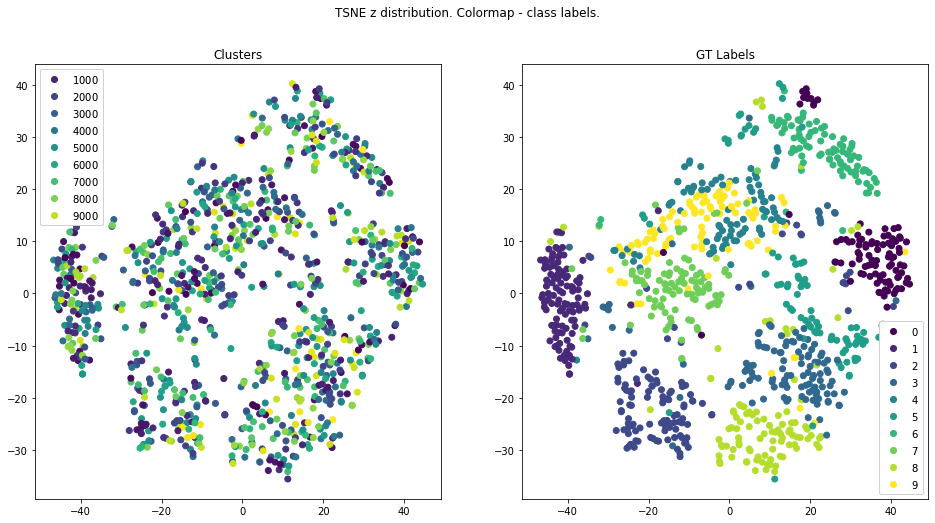

In [68]:
plot_clusters(latents, clusterizer.labels_, targets)

In [73]:
centroids = clusterizer.cluster_centers_

In [75]:
%timeit -n 1 -r 1 centroid_clusterizer = MiniBatchKMeans(n_clusters=1_000, init='k-means++').fit(centroids)

1.83 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


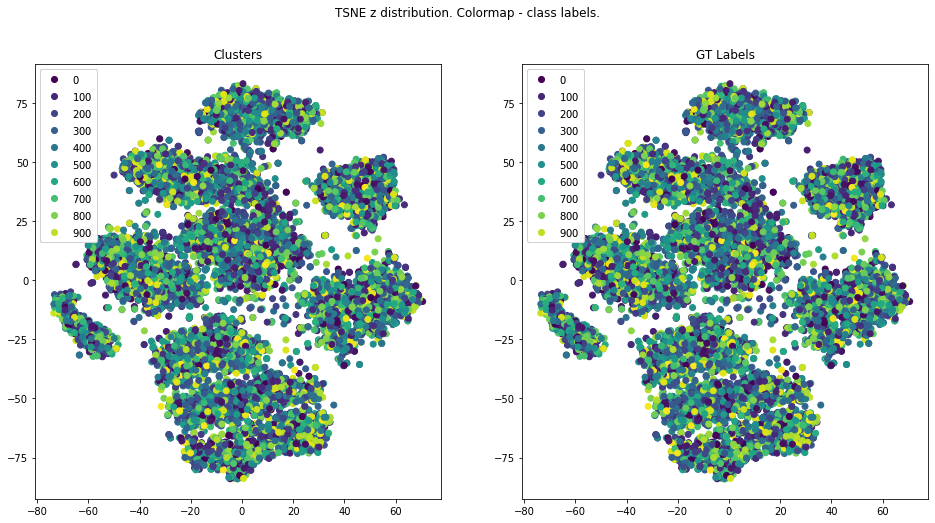

In [76]:
plot_clusters(centroids, centroid_clusterizer.labels_, centroid_clusterizer.labels_, step=1)

In [79]:
centroids = centroid_clusterizer.cluster_centers_

In [82]:
%timeit -n 1 -r 1 centroid_clusterizer = MiniBatchKMeans(n_clusters=200, init='k-means++').fit(centroids)

342 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [203]:
class Node(nn.Module):
    def __init__(self, value, parent=None, device=torch.device('cpu')):
        super(Node, self).__init__()
        self.device = device
        self.value_ = nn.Parameter(torch.tensor(value, device=device))
        self.parent_ = parent
    
    def set_value(self, value):
        self.value_ = nn.Parameter(torch.tensor(value, device=self.device))
    
    def set_parent(self, parent):
        self.parent_ = parent
        
    def parent(self):
        return self.parent_
        
    def forward(self):
        return self.value_
    
    def __str__(self):
        return f'Node(\nvalue: {self.value_}\nparent: {self.parent_})'


class LatentTree(nn.Module):
    def __init__(self, latents, node_degree, sparse, verbose=False):
        super(LatentTree, self).__init__()
        self.latents = latents
        self.node_degree = node_degree
        self.sparse = sparse
        self.verbose = verbose
        self.create_tree_()
        
    def forward(self, idx):
        return self.node_sum_(idx)

    def rebuild(self):
        device = next(iter(self.parameters())).device
        idx = torch.arange(0, len(self.latents), device=device)
        self.latents = self(idx).to(torch.device('cpu'))
        self.create_tree_()
        return self
    
    def node_sum_(self, idx):
        lat = 0
        for i, embed in enumerate(self.node_values.values()):
            lat += embed(idx)
            if i < len(self.nodes):
                idx = torch.tensor(self.nodes[i][idx])
        return lat
    
    def create_tree_(self):
        self.depth = 0
        self.nodes = nn.ParameterList()
        self.node_values = nn.ModuleDict()
        data = self.latents.clone().detach()
        n_centroids = len(data) // self.node_degree
        
        kmeans = MiniBatchKMeans(n_clusters=n_centroids, init='k-means++').fit(data)
        labels = kmeans.labels_
        centroids = torch.zeros_like(torch.tensor(kmeans.cluster_centers_))
        for label in np.unique(labels):
            label_idx = np.argwhere(labels==label).T
            centroids[label] = torch.mean(data[label_idx], dim=0)
            data[label_idx] -= centroids[label]
        self.node_values.update({str(self.depth): nn.Embedding.from_pretrained(data.clone().detach(), 
                                                                               freeze=False, 
                                                                               sparse=self.sparse)})
        self.nodes.append(nn.Parameter(torch.tensor(labels).long(), requires_grad=False))
        if self.verbose:
            print(f'Created {len(data)} initial nodes at height {self.depth}')
        data = centroids
        n_centroids = len(data) // self.node_degree
        self.depth += 1
        
        while n_centroids > 1:
            kmeans = MiniBatchKMeans(n_clusters=n_centroids, init='k-means++').fit(data)
            labels = kmeans.labels_
            centroids = torch.zeros_like(torch.tensor(kmeans.cluster_centers_))
            for label in np.unique(labels):
                label_idx = np.argwhere(labels==label).T
                centroids[label] = torch.mean(data[label_idx], dim=0)
                data[label_idx] -= centroids[label]
            self.node_values.update({str(self.depth): nn.Embedding.from_pretrained(data.clone().detach(), 
                                                                                   freeze=False, 
                                                                                   sparse=self.sparse)})
            self.nodes.append(nn.Parameter(torch.tensor(labels).long(), requires_grad=False))
            if self.verbose:
                print(f'Created {len(data)} nodes at height {self.depth}')
            data = centroids
            n_centroids = len(data) // self.node_degree
            self.depth += 1
            
        self.node_values.update({str(self.depth): nn.Embedding.from_pretrained(data.clone().detach(), 
                                                                               freeze=False, 
                                                                               sparse=self.sparse)})
        if self.verbose:
                print(f'Created {len(data)} nodes at height {self.depth}')
        

In [195]:
latents

tensor([[-0.0166, -0.2216, -0.0472,  ...,  0.0136,  0.0095,  0.0345],
        [ 0.5107, -0.1540,  0.3230,  ..., -0.1029,  0.0999, -0.0865],
        [-0.0337,  0.2709, -0.1053,  ..., -0.2355, -0.0178,  0.1477],
        ...,
        [-0.1610,  0.1323, -0.2210,  ..., -0.1157, -0.0603, -0.0517],
        [ 0.0740,  0.0502,  0.3453,  ...,  0.0216,  0.0397, -0.1480],
        [-0.1503, -0.0682,  0.4065,  ...,  0.0800, -0.0522,  0.1018]])

In [196]:
Y = latents[::100]

In [197]:
Y

tensor([[-0.0166, -0.2216, -0.0472,  ...,  0.0136,  0.0095,  0.0345],
        [-0.2426,  0.1145, -0.0018,  ..., -0.1352, -0.1928,  0.1470],
        [-0.4356, -0.0246, -0.0106,  ..., -0.0295, -0.1761, -0.0364],
        ...,
        [-0.2707,  0.2557,  0.3285,  ..., -0.0131, -0.0215,  0.0844],
        [ 0.1997, -0.0420, -0.0746,  ..., -0.1398,  0.0391,  0.0344],
        [-0.4520, -0.0186,  0.1871,  ...,  0.0611, -0.0172, -0.0949]])

In [232]:
# %timeit -n 1 -r 1 tree = LatentTree(Y, node_degree=5, device='cpu', verbose=True)
tree = LatentTree(Y, node_degree=10, sparse=True, verbose=True)

Created 600 initial nodes at height 0
Created 60 nodes at height 1
Created 6 nodes at height 2


In [233]:
tree.to(torch.device('cpu'))

LatentTree(
  (node_values): ModuleDict(
    (0): Embedding(600, 32, sparse=True)
    (1): Embedding(60, 32, sparse=True)
    (2): Embedding(6, 32, sparse=True)
  )
)

In [234]:
tree.node_values['1'].weight[51]

tensor([ 0.0995, -0.0602, -0.1257, -0.0139, -0.1459,  0.2156,  0.1165,  0.0322,
         0.2106, -0.0116,  0.0789,  0.0668, -0.0335, -0.1260,  0.0388, -0.0273,
         0.0764, -0.0291, -0.0400, -0.0434,  0.0076, -0.0105, -0.0919,  0.0009,
        -0.0481, -0.0147, -0.0455,  0.0971,  0.0208,  0.0124,  0.0116, -0.0243],
       dtype=torch.float64, grad_fn=<SelectBackward0>)

In [235]:
lat = 0
label = torch.tensor([0, 1, 2, 3])
for i, embed in enumerate(tree.node_values.values()):
    lat += embed(label)
    if i < len(tree.nodes):
        label = torch.tensor(tree.nodes[i][label])
    

In [236]:
lat

tensor([[-0.0166, -0.2216, -0.0472, -0.3760, -0.0074, -0.1067,  0.1719,  0.0929,
         -0.2665,  0.0730,  0.1419, -0.2069, -0.0927,  0.5206,  0.1356,  0.0757,
          0.1683,  0.1287,  0.3421,  0.1189,  0.0106, -0.0611,  0.0038,  0.2053,
          0.1289, -0.0170, -0.2007,  0.1244, -0.1021,  0.0136,  0.0095,  0.0345],
        [-0.2426,  0.1145, -0.0018, -0.0138, -0.0896, -0.2721, -0.0995, -0.0970,
          0.1129,  0.3859,  0.0159, -0.3613,  0.1260, -0.1270,  0.2822,  0.1634,
          0.0522,  0.0987, -0.0040,  0.1174, -0.2154, -0.2297,  0.1305,  0.2463,
          0.0251, -0.2962,  0.0383, -0.1456, -0.0308, -0.1352, -0.1928,  0.1470],
        [-0.4356, -0.0246, -0.0106, -0.0056, -0.1223, -0.4377,  0.3296, -0.1542,
         -0.1743,  0.1973,  0.1341,  0.2892,  0.1944, -0.0426,  0.0222, -0.0072,
         -0.1834,  0.0179,  0.0066, -0.1405, -0.0418, -0.0160,  0.1732,  0.0116,
          0.0908, -0.0478, -0.2813, -0.0445, -0.0553, -0.0295, -0.1761, -0.0364],
        [-0.4896, -0.2571

In [237]:
idx = torch.arange(0, 600)
torch.sqrt(torch.sum((tree(idx) - Y[idx])**2))

tensor(6.6529e-07, grad_fn=<SqrtBackward0>)

In [238]:
tree.node_values['0'](torch.tensor(0))

tensor([-0.1565, -0.0716,  0.0321,  0.0493, -0.2177,  0.1395,  0.1474,  0.0690,
        -0.2597,  0.0104,  0.1297, -0.0959, -0.1684,  0.3156,  0.0847,  0.0689,
         0.2034,  0.1433,  0.2474,  0.0547,  0.0317, -0.0373,  0.1159,  0.2363,
         0.1390, -0.0531, -0.1854,  0.0652, -0.0597,  0.0438,  0.0113,  0.0513],
       grad_fn=<EmbeddingBackward0>)

In [239]:
lab, cnt = np.unique(tree.nodes[0], return_counts=True)

In [240]:
lab, cnt

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int32),
 array([30,  1,  7, 10, 14,  7,  1, 17, 20, 17, 13,  4,  3, 10,  5, 12, 35,
        19,  6, 10,  2, 17,  2, 14,  3, 10, 16, 14, 16, 11, 12,  4, 13,  4,
         4, 10,  6,  5, 12, 26,  8, 11,  3,  7, 13,  6, 11,  8,  3, 15, 14,
        12,  4,  2,  2,  5, 16, 10,  3,  5]))

In [20]:
tmp = 0
for i, y in enumerate(Y):
    tmp += torch.sum(y - tree([i]))**2
torch.sqrt(tmp)

tensor(1.8581e-14, dtype=torch.float64, grad_fn=<SqrtBackward>)

In [243]:
tmp.backward()

In [254]:
tree.nodes[99].parent().parent().parent().parent()().grad

tensor([94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94.,
        94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94., 94.,
        94., 94., 94., 94.], dtype=torch.float64)

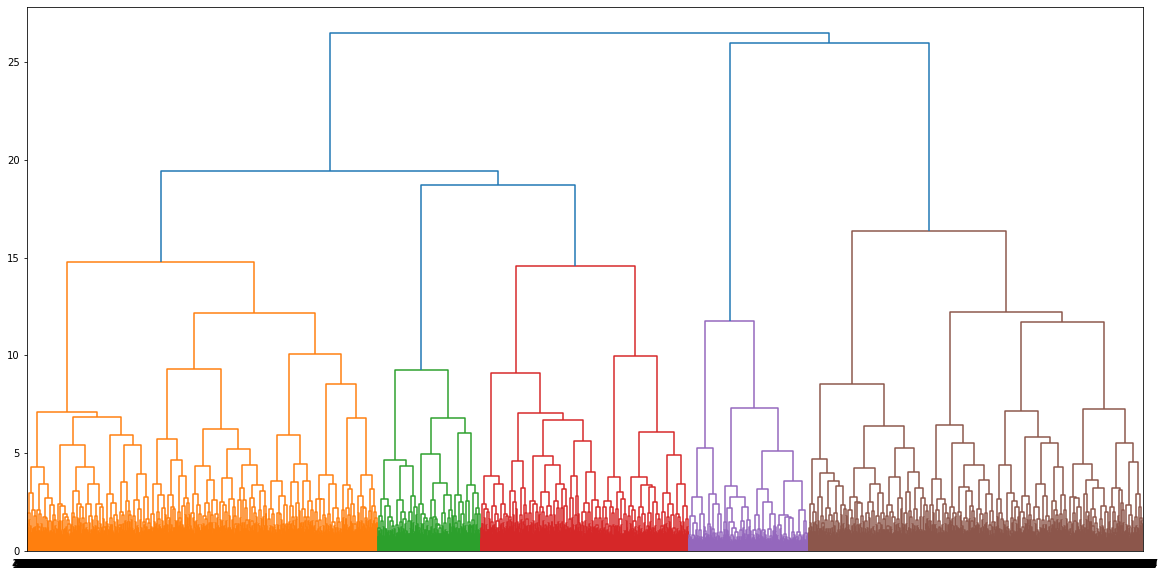

In [100]:
plt.figure(figsize=(20, 10))
plot_dendrogram(clusterizer)

In [85]:
a = nn.Parameter(torch.tensor(10.))
b = nn.Parameter(torch.tensor(12.))
res = (20 * (a+b))

In [87]:
res.backward()

In [91]:
a.grad, b.grad

(tensor(20.), tensor(20.))

In [96]:
torch.argsort(torch.sum((X[0] - X)**2, dim=1))

tensor([   0, 1074, 5254,  ..., 3815, 3492,  116])

In [72]:
torch.sort(torch.sum((X[0] - X)**2, dim=1))

torch.return_types.sort(
values=tensor([0.0000, 1.0840, 1.1948, 1.2937, 1.3862, 1.4300, 1.4353, 1.5153, 1.5244,
        1.5759, 1.5855, 1.5928, 1.6036, 1.6400, 1.6676, 1.6775, 1.6965, 1.7331,
        1.7620, 1.7775, 1.7881, 1.8036, 1.8440, 1.8548, 1.8665, 1.8766, 1.8846,
        1.8893, 1.9064, 1.9115, 1.9768, 1.9848, 1.9968, 2.0305, 2.0384, 2.0393,
        2.0409, 2.0468, 2.0759, 2.0915, 2.0943, 2.1002, 2.1098, 2.1215, 2.1443,
        2.1635, 2.1702, 2.2069, 2.2148, 2.2215, 2.2255, 2.2285, 2.2347, 2.2982,
        2.4098, 2.4135, 2.4992, 2.5883, 2.6026, 2.7321]),
indices=tensor([ 0, 33, 10,  4, 25, 59, 20, 50, 45, 54, 53, 24, 11, 21, 52, 12, 19, 22,
         6, 29, 40, 43, 16, 31, 51, 28,  2, 34, 23, 30,  1, 58, 55, 56, 14, 32,
         7, 36, 41, 42, 46, 15, 39, 35, 44,  8, 38, 48, 27, 57, 49, 26,  3, 47,
         5, 13, 17,  9, 18, 37]))